## In this notebook, I will replicate vision transformer and use it to classify food images.

The paper for the vision transformer is as follows:
<a>https://arxiv.org/abs/2010.11929</a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt




In [2]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn, download_data  # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classe

helper_functions.py already exists, skipping download


### 1. Setup Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/ 'train'
test_dir = image_path/ 'test'

##### 1.1 Load the data into train and test sets

In [5]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=manual_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=manual_transform)

In [7]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=1)

In [8]:
class_names = train_dataset.classes
class_names_indexes = train_dataset.class_to_idx

class_names

['pizza', 'steak', 'sushi']

##### 1.2 visualise a single image

In [9]:
# visualising image from dataset
image, label = train_dataset[0]

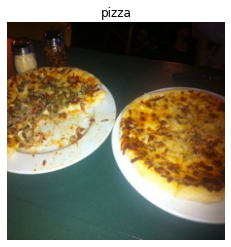

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

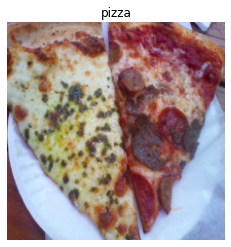

In [11]:
# visualise image from dataloader
image_batch, label_batch = next(iter(train_dataloader))

image_dataloader, label_dataloader = image_batch[0], label_batch[0]

plt.imshow(image_dataloader.permute(1,2,0))
plt.title(class_names[label_dataloader])
plt.axis(False);


**Looks like the data is loading perfectly!**

#### Steps to Build Vision Transformer

The equations that form the base of Vit architecture are as follows:
<img src="/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Vit Architecture equations.png" alt="Alt Text">

In all equations "z" is the raw output of a particular layer.
1. z0 is the output of the initial patch embedding layer
2. zl' is output of an intermediate layer
3. zl is the ouput of a particular layer 

To further understand each equation:
1. <u>**In equations1:**</u> Make the image into patchs and them convert these into position embedding.<br/>
In vector form, the embedding might look something like:
<ul>
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
Where each of the elements in the vector is learnable (their requires_grad=True).
</ul>

2. <u>**In equation 2:**</u> There is a multi head self attention layer wrapping a layer norm . <br/>
There is a skil connection in the end which means additng the inout of some layers to the output of layers. This allows the model to remember both global and local information. Also helps in mitigation the vanishing gradient problem
<ul>x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input </ul>
<ul>Imagine there is a picture, and we want to understand what's happening in different parts of that picture. To do that, we divide the picture into smaller pieces called patches. Each patch is like a mini-picture that the model will analyze.

Equation 2 tells us how to calculate the value of each patch. It says that the value of a patch is determined by a combination of the values of all the patches in the image. This means that each patch looks at the values of all the other patches to figure out its own value.

To do this, the model uses something called "self-attention." Self-attention is like having a conversation between patches. Each patch listens to what the other patches have to say and decides how much it should pay attention to each one. It does this by giving each patch a score, which represents how important that patch is for understanding the current patch.

Once each patch has a score for all the other patches, it multiplies each score by the value of the corresponding patch. Then it adds up all these multiplied values to get the final value of the patch.

So, Equation 2 is like a recipe that tells the model how to calculate the value of each patch by having them talk to each other and combining their information. This helps the model understand different parts of the image and make sense of what it sees.</ul>

3. <u>**In equation 3:**</u> This says that for every layer from through to (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).
<ul>
The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
Notice the skip connection on the end (adding the input of the layers to the output of the layers).</ul>
<ul>Equation 3 is all about updating the values of the patches based on the calculated scores from Equation 2. It tells us how each patch should adjust its value to incorporate information from other patches.</ul>

4. <u>**In equation 4:**</u> This is the last layer and a layer norm is wrapper around the output.
<ul> y = Linear_layer(LN_layer(x_output_MLP_block[0]))</ul>
<ul>the updated patch values are transformed to produce the output of the model. This equation allows the model to make predictions or decisions based on the processed information.

Once each patch has been updated using Equation 3, the model needs to combine all the patch values into a single representation that captures the overall understanding of the image.

Equation 4 tells us how to transform the updated patch values. It involves multiplying the patch values by a set of learnable parameters called weights and adding a bias term. This process is similar to multiplying and adding numbers together to get a result.

The weights and bias terms are learned during the training of the model. They are adjusted to find the best combination that helps the model make accurate predictions based on the processed patch values.

To summarize, Equation 4 takes the updated values of the patches, applies learnable weights and a bias term, and combines them to generate the output of the vision transformer. It transforms the patch values into a compact representation that captures the essential information for decision-making.

</ul>

# 2. Equation 1: split data into patches and add position embeddings

In this i'll start with patch embedding which means the entire image will be broken down into smaller batches and then the idea is to create an embedding (learnable representation of some form or vector) for all the patches. All the embeddings are in numeric form so that they are learnable.
<img src="/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Vit Intro.png" alt="Alt Text">
<li>  D is the size of the patch embeddings, different values for various sized ViT models can be found in Table 1</li>
<li>The image start as 2D with size H X W XC</li>
    <ul><li> (H,W) is the resolution of the image</li></ul>
    <ul><li> C is the number of channels</li></ul>
<li> The image gets converted to a sequence of flattened 2D patches with size N X (P.P.C)</li>
    <ul><li> (P,P) is the resolution of each path</li></ul>
    <ul><li> N = HW/P.P is the resulting number of patches, which is the input sequence length for the transformer</li></ul>

##### 2.1 Calculate path embedding by hand as an example

In [12]:
height = 224
width = 224
color_channels = 3
patches = 16

number_of_patches = int((height*width) / (patches*patches))

print("The number of patches are ",number_of_patches)

The number of patches are  196


In [13]:
# let me convert by hand and see input and output shapes.
embedding_input_shape = (height, width, color_channels)

embedding_output_shape = (number_of_patches, (patches**2)*color_channels)

print(f"Input shape (single 2D image): {embedding_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


##### 2.2 Visualise patches of the image

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


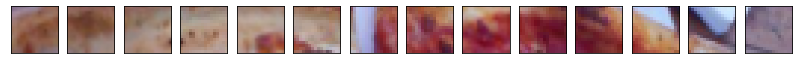

In [14]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image_dataloader.permute(1, 2, 0)

image_size = 224
patch_size = 16
num_patches = image_size/patch_size
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")


fig, axs = plt.subplots(nrows=1, ncols= image_size // patch_size, figsize = (num_patches, num_patches), sharex=True, sharey=True)

for i,patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
    axs[i].set_label(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    

In [15]:
assert image_size % patch_size == 0 # ensure that they are divisible
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# let me now do it for the entire image
fig, axs = plt.subplots(nrows=image_size // patch_size, ncols= image_size // patch_size, figsize = (image_size,image_size), sharex=True, sharey=True)

for i, patch_height in enumerate(range(0, image_size, patch_size)):
    for j, patch_width in enumerate(range(0, image_size, patch_size)):
        
        # Plt the permuted image patch
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

        axs[i,j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i,j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label_dataloader]} -> Patchified", fontsize=16)
plt.show()

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


##### 2.3 Create patches using torch.nn.Conv2d()

Image that a patch is similar to a convolution block. as each convolution block passes through the image, it can form a patch. This can then be flattened.<br/>
Example:<br/>
Image of size 224,224<br/>
input is of shape - (224, 224, 3)
output is of shape - (196, 769)<br/>

we can replicate the creation of patches by using torch.nn.conv2d() with kernersize and stride = patch size <br/>


In [16]:
patch_size = 16

conv2d = torch.nn.Conv2d(in_channels=3, # Number of color channels
                out_channels= 768, # in Table 1: Hidden size D, this is embedding size
                kernel_size=patch_size, # can also be written as (patch_size, patch_size)
                stride=patch_size,
                padding=0)

In [17]:
# let me pass the image through the conv2d created
conv2d(image_dataloader).shape # this does not have a batch size. It has (embedding_dim, feature_map_height, feature_map_width)

torch.Size([768, 14, 14])

In [18]:
# add dimension after passing through conv2d
conv2d(image_dataloader.unsqueeze(0)).shape # now the shape has batch size. (batch_size, embedding_dim, feature_map_height, feature_map_width)

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [307, 523, 82, 643, 413]


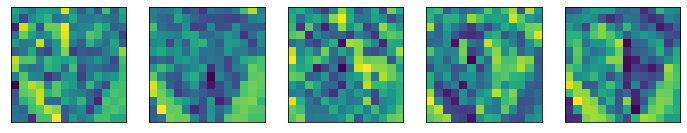

In [19]:
import random

image_out_of_conv = conv2d(image_dataloader.unsqueeze(0))

# I'll check out few feature maps among the 768
random_indexes = random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, index in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, index, :,:] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


##### 2.4 Now Flatten the patches that has come out of conv2d 



In [20]:
flatten = torch.nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


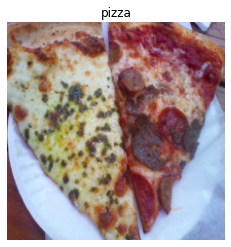

In [21]:
# put all together
plt.imshow(image_dataloader.permute(1,2,0))
plt.title(class_names[label_dataloader])
plt.axis(False);
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image_dataloader.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Input was given - (224,224)<br/>
desired output - (196, 768) -> N X (P**2.C)<br/>
current output is - (1, 768, 196)<br/>

The difference is shape size and the order is different

In [22]:
# I will use permute to get to the desired output
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


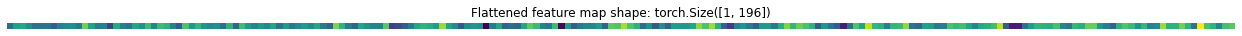

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

##### 2.5 Turning the ViT patch embedding layer into Pytorch Module

In [24]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()

        # create a convolution layer to turn image into patches
        self.patcher = torch.nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim , kernel_size=patch_size, stride=patch_size, padding=0)

        # create a layer to flatten the patch
        self.flatten = torch.nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        # create assertion to check image size is divisible by patch size
        assert image_resolution % patch_size == 0

        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1) 


In [25]:
# let me try it out on 1 image
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image_dataloader.unsqueeze(0).shape}")
patch_embedded_image = patchify(image_dataloader.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


##### 2.6 Create class Token

prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension. <br/>
<p><b><u>Psudo code:</u></b><br/>
patch_embedding = [image_patch_1, image_patch_2,...]<br/>
class_token = learnable embedding <br/>
patch_embedding_with_class_token = torch.cat((class_toke, patch_embedding), dim=1)
</p>

<u>**Create class token embeddings with torch.rand and not torch.ones**</u>

In [26]:
# create a learnable embedding for class token
# steps: 1. get get the batch size and embedding dimension shape and then create a torch.ones() tensor in the shape [batch_size, 1, embedding_dimension].
# Mke the tensor learnable by passing it to nn.Parameter() with requires_grad=True.
batch_size = patch_embedded_image.shape[0]
embedding_dimension_shape = patch_embedded_image.shape[-1]

class_token_embedding = torch.nn.Parameter(torch.ones(batch_size, 1, embedding_dimension_shape), requires_grad=True)

# Show the first 10 examples of the class_token
print(class_token_embedding[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token_embedding.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [27]:
# Add the class token embedding to the front of the patch embedding
patch_embedding_image_with_class_embedding = torch.cat((class_token_embedding, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedding_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedding_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1087, -0.2957,  0.3122,  ...,  0.1626, -0.1828,  0.1532],
         [-0.0221, -0.2249,  0.2724,  ...,  0.1859, -0.2036,  0.2214],
         ...,
         [-0.0113, -0.6362,  0.7489,  ...,  0.1598, -0.2682,  0.6092],
         [ 0.1032, -0.4860,  0.5586,  ...,  0.0610, -0.2331,  0.5709],
         [ 0.1104, -0.4805,  0.5441,  ...,  0.0451, -0.2142,  0.5770]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


##### 2.7 Create Positional Embeddings and add it to classembedding+patches

In [28]:
patch_embedding_image_with_class_embedding, patch_embedding_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1087, -0.2957,  0.3122,  ...,  0.1626, -0.1828,  0.1532],
          [-0.0221, -0.2249,  0.2724,  ...,  0.1859, -0.2036,  0.2214],
          ...,
          [-0.0113, -0.6362,  0.7489,  ...,  0.1598, -0.2682,  0.6092],
          [ 0.1032, -0.4860,  0.5586,  ...,  0.0610, -0.2331,  0.5709],
          [ 0.1104, -0.4805,  0.5441,  ...,  0.0451, -0.2142,  0.5770]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

#### Equation 1 states that E pos belongs to Real numbers having shape (N + 1) X D
<img src = '/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Equation1.png'>
<p>
N = number of patches = HW / P**2<br/>
D = Patch embeddings
</p>

In [29]:
# calculate number of patches
number_of_patches = int((height*width) / patch_size**2)

# get embedding dimension
embedding_dimension = patch_embedding_image_with_class_embedding.shape[-1]

# create position embedding
postion_embedding = torch.nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)


# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(postion_embedding[:, :10, :10])
print(f"Position embeddding shape: {postion_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
# now add the position embedding to the class token embedding
patch_and_position_embedding = patch_embedding_image_with_class_embedding + postion_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8913, 0.7043, 1.3122,  ..., 1.1626, 0.8172, 1.1532],
         [0.9779, 0.7751, 1.2724,  ..., 1.1859, 0.7964, 1.2214],
         ...,
         [0.9887, 0.3638, 1.7489,  ..., 1.1598, 0.7318, 1.6092],
         [1.1032, 0.5140, 1.5586,  ..., 1.0610, 0.7669, 1.5709],
         [1.1104, 0.5195, 1.5441,  ..., 1.0451, 0.7858, 1.5770]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


#### 2.8 Putting it all together
<img src='/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Equation1.png'><br/>
1. Get the patch size
2. Get single Image
3. Make patche embeddings by passing through conv layer 
4. Flatten the patch embeddings by passing through torch.nn.Flatten()
5. create a class token embedding which is learnable
6. Add class token embedding on dimenion 1 to the patch embeddings
7. Create position embedding
8. Add the position embeddings to (class_token and patch _embeddings) created in step 6.

In [31]:
# 1. Get the patch size
patch_size = 16

# 2. Get single image
image_patches, label_patches = next(iter(train_dataloader))
image, label = image_patches[0], label_patches[0]
print(f"Image tensor shape: {image.shape}")
print(f"Input image with batch dimension shape: {image.unsqueeze(0).shape}")


# 3 & 4. Unsqueeze the image and pass it through PatchEmbedding class (Conv layer + Flatten) to make it a patch embedding
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
patch_embedding = patch_embedding_layer(image.unsqueeze(0))
print(f"Patching embedding shape: {patch_embedding.shape}")

# 5. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = torch.nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")


# 6. Add class token embedding to patch embedding
class_token_embedding_with_patch_embedding = torch.cat((class_token, patch_embedding), dim =1)
print(f"Patch embedding with class token shape: {class_token_embedding_with_patch_embedding.shape}")


# 7. Create postion embedding
number_of_patches = int((height*width) / patch_size**2)
postion_embedding = torch.nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# 8. Add position embedding to patch embedding with class token
patch_and_position_embedding = class_token_embedding_with_patch_embedding + postion_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 3. Equation 2: Add the MSA Layer

In this there is a multihead self attention which is wrapps a layer norm with a residual connection
<img src="/Users/akhil/VSCodeProjects/Pytorch-Vision-Transformer/Equation2.png">
To replicate these layers and residual connection with PyTorch code we can use:

1. Multi-Head Self Attention (MSA) - torch.nn.MultiheadAttention().
2. Norm (LN or LayerNorm) - torch.nn.LayerNorm().
3. Residual connection - add the input to output 

In [33]:
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dimension = 768, num_heads = 12, attn_dropout=0) -> None:
        super().__init__()

        self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dimension)

        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim=embedding_dimension, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):

        x = self.layer_norm(x)

        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# 4. Equation 3: Add the MSP Layer

In this there is a multi Layer Percentronwhich is wrapps a layer norm with a residual connection
<img src="/Users/akhil/VSCodeProjects/Pytorch-Vision-Transformer/Equation3.png"><br/>
To replicate these layers and residual connection with PyTorch code we can use:

1. Multi Layer Perceptron (MlP) - This quite broad as it can refer to almost any combination of multiple layers. <br/>
    1.1. Linear layer -> Non Linear Layer -> Linear Layer -> Non Linear Layer
2. Norm (LN or LayerNorm) - torch.nn.LayerNorm().
3. Residual connection - add the input to output 

In [44]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, embedding_dimension = 768, mlp_size = 3072, dropout:float=0.1) -> None:
        super().__init__()

        self.mlp_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=embedding_dimension, out_features=mlp_size),
            torch.nn.GELU(),
            torch.nn.Dropout(),
            torch.nn.Linear(in_features=mlp_size, out_features=embedding_dimension),
            torch.nn.Dropout(),
        )

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

    def forward(self, x):
        x = self.layer_norm(x)

        x = self.mlp_block(x)

        return x


# 5. Creating a Transformer Encoder by combining our custom made layers

Make a ViT Transformer Encoder with PyTorch by combining our previously created layers.

To do so, I will:

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a forward() method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [45]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttention(embedding_dimension=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MultiLayerPerceptron(embedding_dimension=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [46]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

In [47]:
transformer_encoder_block

TransformerEncoderBlock(
  (msa_block): MultiHeadSelfAttention(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MultiLayerPerceptron(
    (mlp_block): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.5, inplace=False)
    )
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)

# 6. Putting all the steps together

To create the full architecture, I will also need to stack a number of our TransformerEncoderBlocks on top of each other, I can do this by passing a list of them to torch.nn.Sequential() (this will make a sequential range of TransformerEncoderBlocks).

Finally, to bring our own implementation of ViT to life:

1. Create a class called ViT that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula , where  is the image height,  is the image width and  is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the PatchEmbedding class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of TransformerEncoderBlocks to torch.nn.Sequential()(equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a torch.nn.LayerNorm() (LN) layer and a torch.nn.Linear(out_features=num_classes) layer (where num_classes is the target number of classes) linear layer to torch.nn.Sequential().
11. Create a forward() method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using torch.Tensor.expand() (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using torch.cat().
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9.
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10.

In [49]:
class ViT(torch.nn.Module):
    def __init__(self, img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000):
        super().__init__()
        assert image_size % patch_size == 0

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = torch.nn.Parameter(data = torch.randn(batch_size, 1, embedding_dim), requires_grad=True)

        self.position_embedding = torch.nn.Parameter(data = torch.randn(batch_size, self.num_patches+1 , embedding_dim), requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )


    def forward(self, x):

        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x
        



In [50]:
vit = ViT(num_classes=len(class_names))

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


In [51]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Pass the random image tensor to our ViT instance to see if it's working.
vit(random_image_tensor)

tensor([[ 1.0834,  0.1081, -0.2383]], grad_fn=<AddmmBackward0>)